This is our notebook for our preliminary data cleaning and logistic regression model.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from dateutil import parser
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from datetime import datetime as DAMN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



In [2]:
df = pd.read_csv("data.csv")
print(df.size)

142049446


In [3]:
def convert_to_datetime(row):
    dt = parser.parse(row["Date"])
    return dt

def label_month(row):
    dt = row["Datetime"]
    return dt.month

def label_hour(row):
    dt = row["Datetime"]
    return dt.year

In [4]:
# Drop all data not within last 5 years
df = df[df['Year'].map(int) > 2013]

In [5]:
# Convert Date to Month and Hour
df["Datetime"] = df.apply(lambda row : convert_to_datetime(row), axis = 1)
df["Month"] = df.apply(lambda row : label_month(row), axis = 1)
df["Hour"] = df.apply(lambda row : label_hour(row), axis = 1)

df['sin_hour'] = np.sin(2*np.pi*df["Hour"]/24)
df['cos_hour'] = np.cos(2*np.pi*df["Hour"]/24)

df['sin_month'] = np.sin(2*np.pi*(df["Month"] - 1)/12)
df['cos_month'] = np.cos(2*np.pi*(df["Month"] - 1)/12)

In [6]:
# Convert district to int and arrest and domestic to binary 0, 1 value
df["District"] = df["District"].astype(int) 
df[["Arrest", "Domestic"]] = df[["Arrest", "Domestic"]].astype(int)

In [7]:
# Drop unnecessary columns
df.drop(["ID", "Case Number", "Date", "IUCR", "Block", "Beat", "Ward", "FBI Code", "Updated On", "Location", "Year", "Datetime", "Month", "Hour"], inplace=True, axis=1)

In [8]:
# Drop rows with crime type that we don't think matter
df = df[
    (df["Primary Type"] != "GAMBLING") &
    (df["Primary Type"] != "LIQUOR LAW VIOLATION") &
    (df["Primary Type"] != "PROSTITUTION") &
    (df["Primary Type"] != "NARCOTICS") &
    (df["Primary Type"] != "PUBLIC INDECENCY") 
    ]

In [9]:
print(df.size)

14018070


In [10]:
# Drop all location features except for District for preliminary model 
df.drop(["X Coordinate", "Y Coordinate", "Latitude", "Longitude", "Community Area"], inplace=True, axis=1)

In [11]:
df[:100]

,Primary Type,Description,Location Description,Arrest,Domestic,District,sin_hour,cos_hour,sin_month,cos_month
1842704,BATTERY,SIMPLE,STREET,0,0,18,-0.5,0.866025,0.0,1.0
1842705,THEFT,FROM BUILDING,BAR OR TAVERN,0,0,18,-0.5,0.866025,0.0,1.0
1842712,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,0,0,15,-0.5,0.866025,0.0,1.0
1842713,BATTERY,SIMPLE,APARTMENT,1,0,25,-0.5,0.866025,0.0,1.0
1842717,BATTERY,SIMPLE,STREET,0,0,12,-0.5,0.866025,0.0,1.0
1842718,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,RESIDENTIAL YARD (FRONT/BACK),1,0,8,-0.5,0.866025,0.0,1.0
1842720,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,RESIDENCE,0,0,25,-0.5,0.866025,0.0,1.0
1842725,OTHER OFFENSE,OTHER WEAPONS VIOLATION,RESIDENTIAL YARD (FRONT/BACK),1,0,11,-0.5,0.866025,0.0,1.0
1842727,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,1,1,25,-0.5,0.866025,0.0,1.0
1842728,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,RESIDENTIAL YARD (FRONT/BACK),0,0,25,-0.5,0.866025,0.0,1.0


In [24]:
print(df.size)
df.dropna(inplace = True)
print(df.size)

9345380
9324840


In [23]:
crime.describe()

,Arrest,Domestic,sin_hour,cos_hour,sin_month,cos_month,Primary Type_ARSON,Primary Type_ASSAULT,Primary Type_BATTERY,Primary Type_BURGLARY,...,District_15,District_16,District_17,District_18,District_19,District_20,District_22,District_24,District_25,District_31
count,934538.000000,934538.000000,9.345380e+05,934538.000000,9.345380e+05,9.345380e+05,934538.000000,934538.000000,934538.000000,934538.000000,...,934538.000000,934538.000000,934538.000000,934538.000000,934538.000000,934538.000000,934538.000000,934538.000000,934538.000000,934538.000000
mean,0.171723,0.170133,-1.406911e-01,0.949154,2.710068e-02,-9.153804e-02,0.001851,0.073000,0.201275,0.055863,...,0.038212,0.035773,0.029955,0.049590,0.046987,0.016830,0.032977,0.028930,0.055416,0.000018
std,0.377140,0.375750,2.769123e-01,0.051312,7.018301e-01,7.059192e-01,0.042986,0.260136,0.400953,0.229657,...,0.191709,0.185723,0.170463,0.217097,0.211611,0.128633,0.178576,0.167609,0.228790,0.004265
min,0.000000,0.000000,-5.000000e-01,0.866025,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-5.000000e-01,0.866025,-5.000000e-01,-8.660254e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,-2.588190e-01,0.965926,1.224647e-16,-1.836970e-16,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,7.847643e-15,1.000000,8.660254e-01,5.000000e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,2.588190e-01,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
# One Hot Encoded (Categorical Data): Primary Type, Description, Location Description, District
crime = pd.get_dummies(df, columns =['Primary Type', 'Description', 'Location Description', 'District'])

In [ ]:
crime[:100]

In [26]:
list(crime.columns)



['Arrest',
 'Domestic',
 'sin_hour',
 'cos_hour',
 'sin_month',
 'cos_month',
 'Primary Type_ARSON',
 'Primary Type_ASSAULT',
 'Primary Type_BATTERY',
 'Primary Type_BURGLARY',
 'Primary Type_CONCEALED CARRY LICENSE VIOLATION',
 'Primary Type_CRIM SEXUAL ASSAULT',
 'Primary Type_CRIMINAL DAMAGE',
 'Primary Type_CRIMINAL TRESPASS',
 'Primary Type_DECEPTIVE PRACTICE',
 'Primary Type_HOMICIDE',
 'Primary Type_HUMAN TRAFFICKING',
 'Primary Type_INTERFERENCE WITH PUBLIC OFFICER',
 'Primary Type_INTIMIDATION',
 'Primary Type_KIDNAPPING',
 'Primary Type_MOTOR VEHICLE THEFT',
 'Primary Type_NON - CRIMINAL',
 'Primary Type_NON-CRIMINAL',
 'Primary Type_NON-CRIMINAL (SUBJECT SPECIFIED)',
 'Primary Type_OBSCENITY',
 'Primary Type_OFFENSE INVOLVING CHILDREN',
 'Primary Type_OTHER NARCOTIC VIOLATION',
 'Primary Type_OTHER OFFENSE',
 'Primary Type_PUBLIC PEACE VIOLATION',
 'Primary Type_ROBBERY',
 'Primary Type_SEX OFFENSE',
 'Primary Type_STALKING',
 'Primary Type_THEFT',
 'Primary Type_WEAPONS VIO

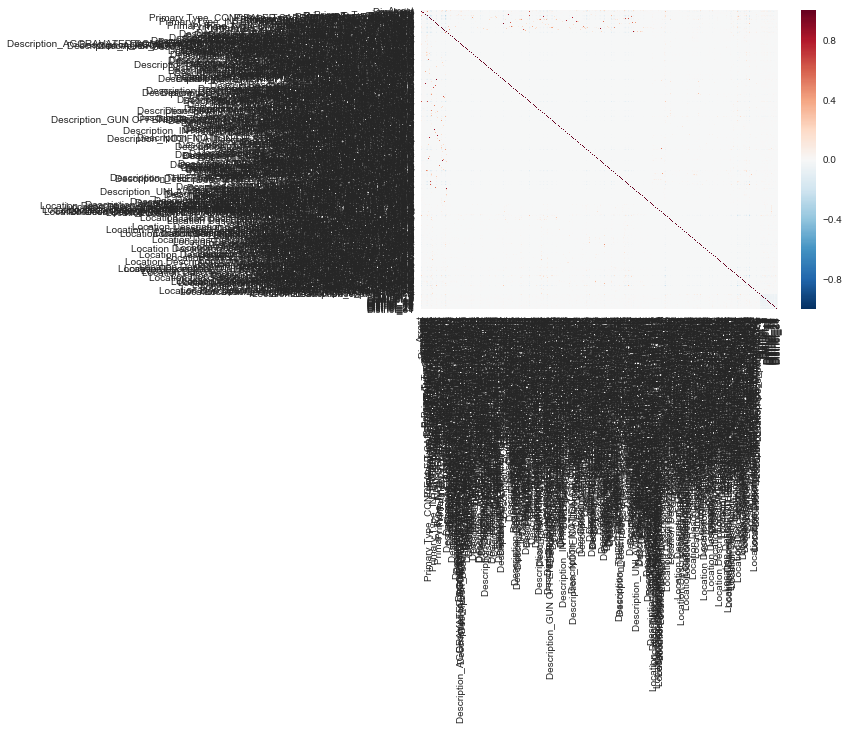

In [27]:
sns.heatmap(crime.corr())
plt.show()

In [31]:
y = crime["Arrest"].copy(True)
X = crime.iloc[:,1:].copy(True)
print(y)
print(X)


1842704    0
1842705    0
1842712    0
1842713    1
1842717    0
1842718    1
1842720    0
1842725    1
1842727    1
1842728    0
1842729    1
1842730    0
1842732    1
1842733    0
1842735    1
1842737    0
1842738    1
1842740    0
1842741    0
1842743    0
1842744    1
1842745    1
1842747    1
1842749    1
1842753    1
1842754    1
1842755    1
1842756    1
1842757    1
1842758    1
1842759    1
1842760    1
1842761    1
1842762    0
1842764    1
1842765    1
1842766    1
1842767    1
1842769    1
1842770    1
1842771    1
1842773    1
1842774    1
1842775    0
1842776    1
1842777    1
1842779    1
1842780    1
1842782    0
1842783    1
1842785    1
1842786    0
1842788    0
1842789    1
1842790    0
1842791    0
1842793    0
1842794    1
1842795    0
1842798    1
1842799    1
1842800    0
1842804    1
1842805    0
1842806    0
1842807    1
1842808    0
1842809    1
1842810    0
1842812    0
1842813    1
1842814    0
1842815    0
1842816    0
1842817    1
1842818    1
1842819    0

         Domestic      sin_hour  cos_hour     sin_month     cos_month  \
1842704         0 -5.000000e-01  0.866025  0.000000e+00  1.000000e+00   
1842705         0 -5.000000e-01  0.866025  0.000000e+00  1.000000e+00   
1842712         0 -5.000000e-01  0.866025  0.000000e+00  1.000000e+00   
1842713         0 -5.000000e-01  0.866025  0.000000e+00  1.000000e+00   
1842717         0 -5.000000e-01  0.866025  0.000000e+00  1.000000e+00   
1842718         0 -5.000000e-01  0.866025  0.000000e+00  1.000000e+00   
1842720         0 -5.000000e-01  0.866025  0.000000e+00  1.000000e+00   
1842725         0 -5.000000e-01  0.866025  0.000000e+00  1.000000e+00   
1842727         1 -5.000000e-01  0.866025  0.000000e+00  1.000000e+00   
1842728         0 -5.000000e-01  0.866025  0.000000e+00  1.000000e+00   
1842729         0 -5.000000e-01  0.866025  0.000000e+00  1.000000e+00   
1842730         1 -5.000000e-01  0.866025  0.000000e+00  1.000000e+00   
1842732         0 -5.000000e-01  0.866025  0.000000

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = DAMN.now().second)


In [40]:
X_train.shape

(745987, 469)

In [41]:
X_test.shape

(186497, 469)

In [42]:
y_train.shape

(745987,)

In [43]:
y_test.shape

(186497,)

In [44]:
classifier = LogisticRegression(random_state = DAMN.now().second)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
y_pred = classifier.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[151079   3341]
 [ 19026  13051]]


In [47]:
classifier.score(X_test, y_test)

0.88006777588915641

In [49]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.89      0.98      0.93    154420
          1       0.80      0.41      0.54     32077

avg / total       0.87      0.88      0.86    186497

